### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import A2C

!pip install quantstats
import quantstats as qs

   ---------------------------------------- 45.5/45.5 kB 1.1 MB/s eta 0:00:00


### Create Env

In [3]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()

window_size = 10
start_index = window_size
end_index = len(df)

env = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


### Train Env

In [4]:
env.reset(seed=2023)
model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=1_000)

### Test Env

In [5]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 907, <Actions.Buy: 1>: 1417}
info: {'total_reward': 869.8982238769531, 'total_profit': 0.0008273490439934051, 'position': <Positions.Long: 1>}


### Plot Results

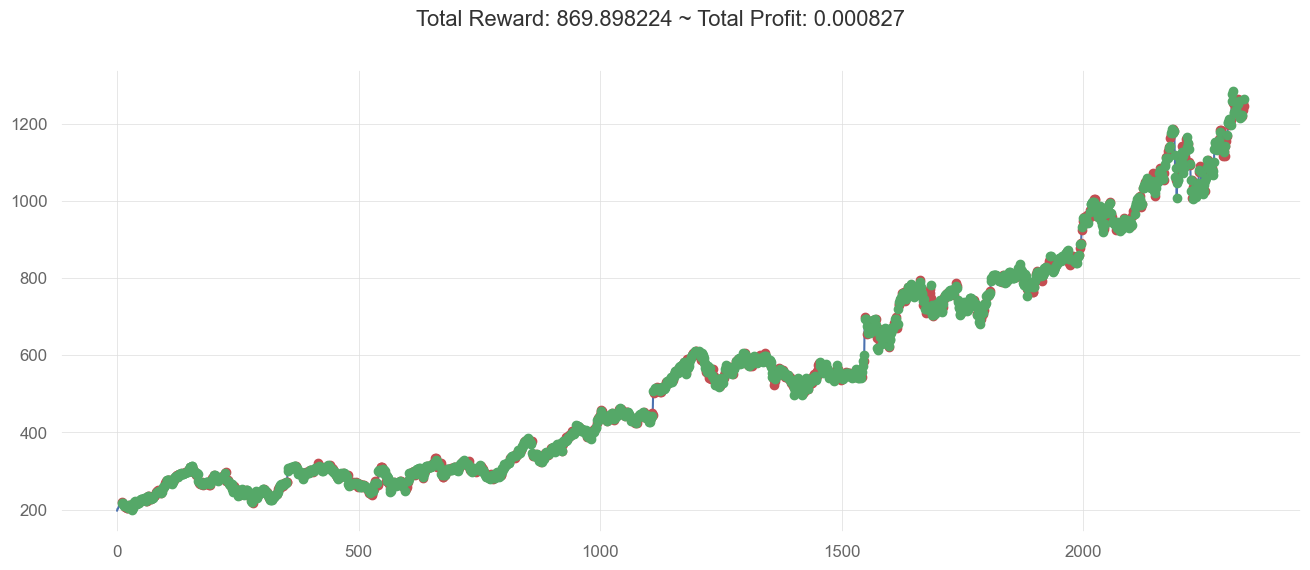

In [6]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

### Analysis Using `quantstats`

                           Strategy
-------------------------  ----------
Start Period               2009-06-10
End Period                 2018-08-29
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          -99.92%
CAGR﹪                     -41.21%

Sharpe                     -3.88
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -3.66
Sortino                    -4.18
Smart Sortino              -3.94
Sortino/√2                 -2.96
Smart Sortino/√2           -2.78
Omega                      0.22

Max Drawdown               -99.92%
Longest DD Days            3362
Volatility (ann.)          19.31%
Calmar                     -0.41
Skew                       -1.38
Kurtosis                   20.8

Expected Daily %           -0.31%
Expected Monthly %         -6.19%
Expected Yearly %          -50.82%
Kelly Criterion            -84.75%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.3%
Expected Shortfall (cVaR)  -2.3%

Max Consecutiv

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-06-16,2018-08-23,2018-08-29,3362,-99.917265,-99.908608


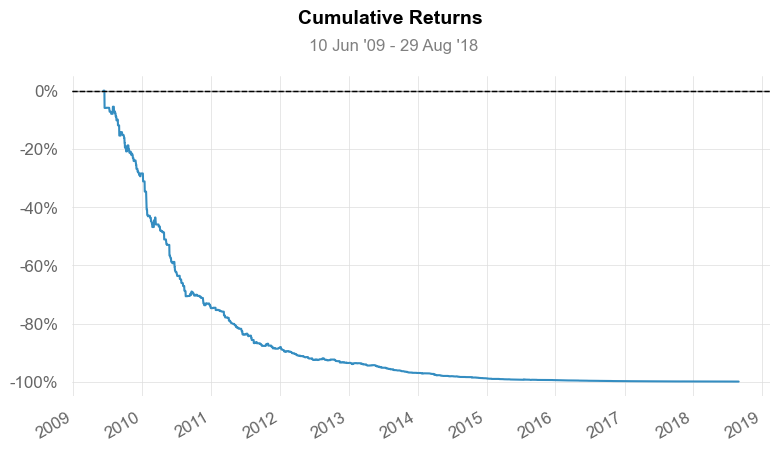

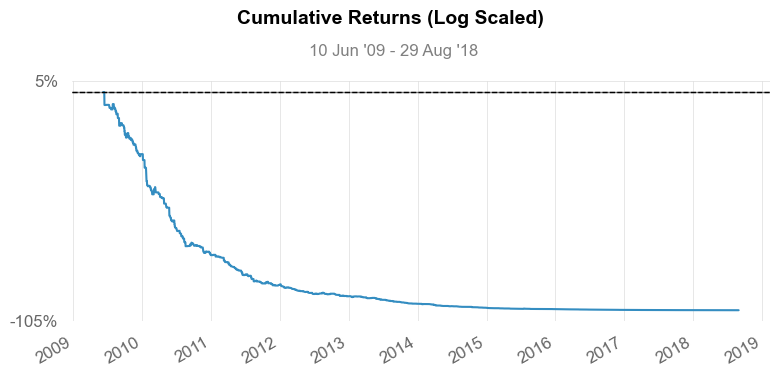

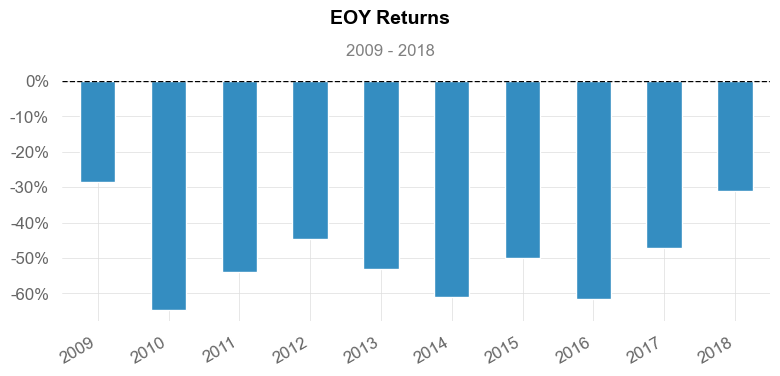

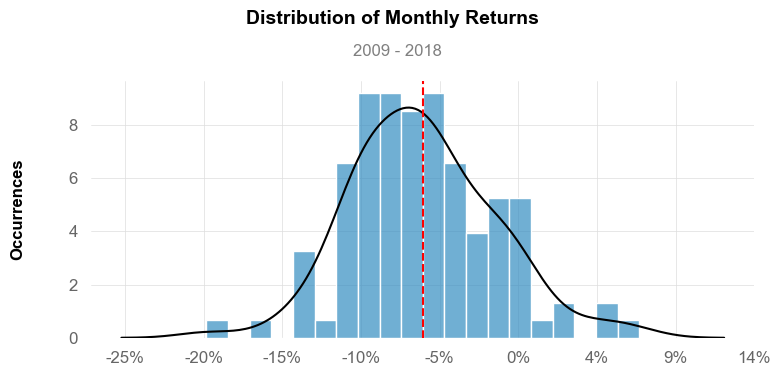

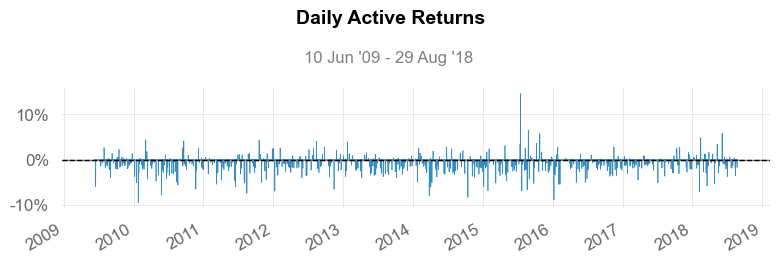

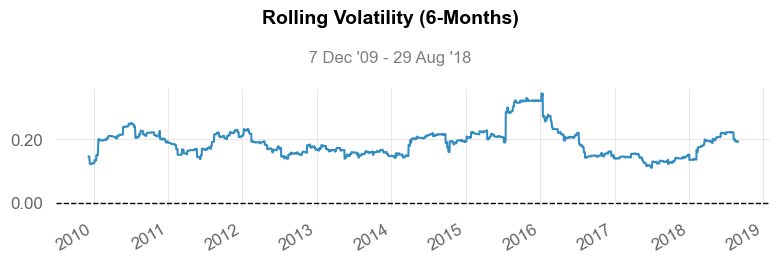

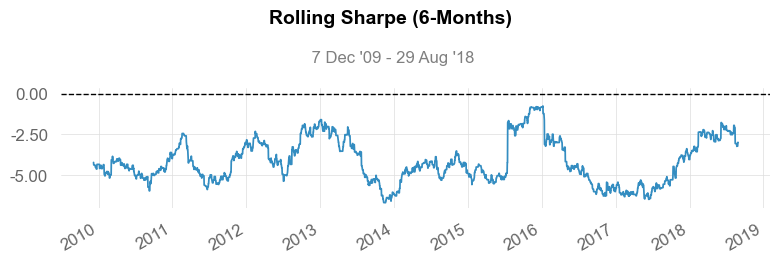

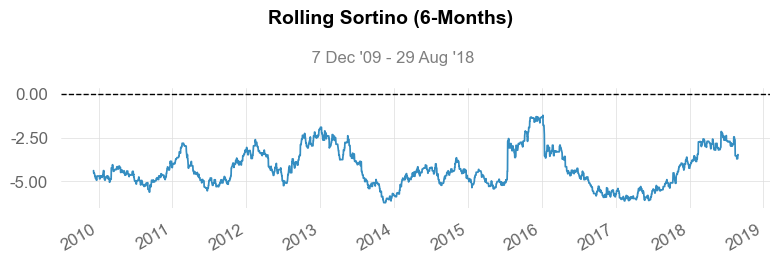

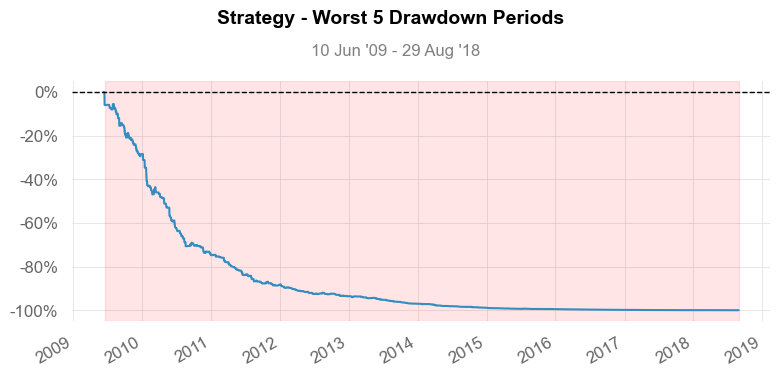

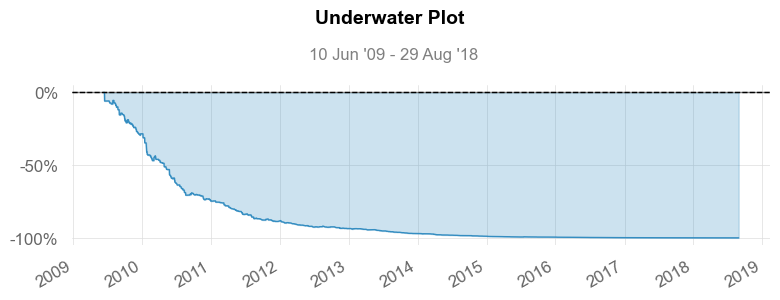

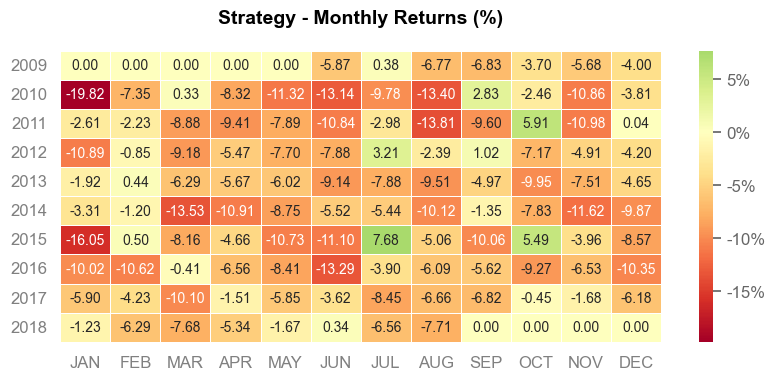

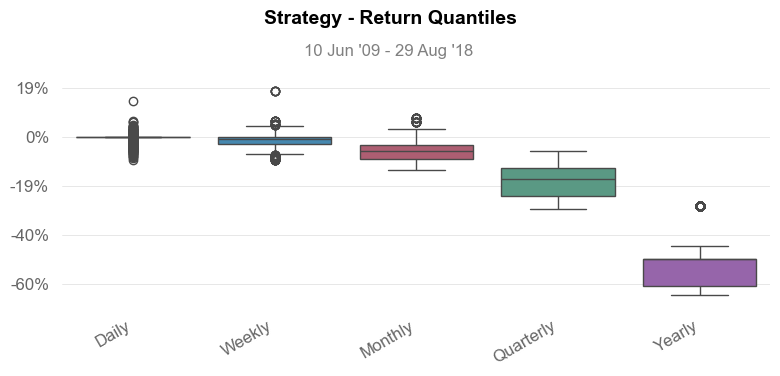

In [7]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output='SB3_a2c_quantstats.html')